<a href="https://colab.research.google.com/github/The20thDuck/Neuro-140-Project/blob/main/main_experiments/FashionGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch as t
import torchvision
from tqdm import tqdm
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.colors import Colormap
!pip install wandb -qqq
import wandb

     |████████████████████████████████| 1.8 MB 3.7 MB/s 
     |████████████████████████████████| 181 kB 28.1 MB/s 
     |████████████████████████████████| 144 kB 23.8 MB/s 
     |████████████████████████████████| 63 kB 2.0 MB/s 


In [ ]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
train_data = torchvision.datasets.FashionMNIST("data", train=True, transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]), download=True)
train_loader = t.utils.data.DataLoader(train_data, batch_size = 128, shuffle=True, num_workers=2)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



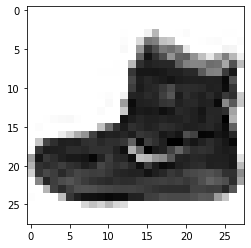

In [ ]:
plt.imshow(train_data[0][0].squeeze(), plt.cm.binary)

In [ ]:
!pip install einops
import einops
ngc = 64
latent_size = 100
num_classes = 10
emb_size = 256

class Generator(t.nn.Module):
  def __init__(self, 
               latent_size=latent_size, 
               num_classes = num_classes, 
               emb_size = 96, 
               nhead=4,
               L1 = 4,
               L2 = 4,
               img_size = 28,
               in_channels=1):
    super().__init__()
    self.emb_size = emb_size
    self.img_size = img_size
    # self.latent_size = latent_size
    self.linear1 = t.nn.Linear(latent_size, emb_size*(img_size//4)**2)
    self.pos_emb1 = t.nn.Parameter(t.randn(1, (img_size//4)**2, emb_size))
    self.block1 = t.nn.Sequential(
        *[t.nn.TransformerEncoderLayer(
        emb_size,
        nhead=nhead, 
        dim_feedforward=emb_size*4, 
        activation="gelu",
        norm_first=True,
        batch_first=True, 
        dropout=0., 
        layer_norm_eps=1e-12
      ) for _ in range(L1)]
    )
    self.pixel1 = t.nn.PixelShuffle(2)

    self.pos_emb2 = t.nn.Parameter(t.randn(1, (img_size//2)**2, emb_size//4))
    self.block2 = t.nn.Sequential(
        *[t.nn.TransformerEncoderLayer(
        emb_size//4,
        nhead=nhead, 
        dim_feedforward=emb_size, 
        activation="gelu",
        norm_first=True,
        batch_first=True, 
        dropout=0., 
        layer_norm_eps=1e-12
      ) for _ in range(L2)]
    )
    self.pixel2 = t.nn.PixelShuffle(2)
    self.project = t.nn.Linear(emb_size//16, in_channels)
    self.tanh = t.nn.Tanh()

  def forward(self, z):
    b = z.shape[0]
    emb = self.linear1(z).view((b, (self.img_size//4)**2, self.emb_size))
    emb = self.block1(emb + self.pos_emb1)
    emb_to_pixel = "b (h w) c -> b c h w"
    pixel_to_emb = "b c h w -> b (h w) c"

    pixels = einops.rearrange(emb, emb_to_pixel, h = self.img_size//4)
    pixels = self.pixel1(pixels)
    emb = einops.rearrange(pixels, pixel_to_emb, h = self.img_size//2)
    emb = self.block2(emb + self.pos_emb2)
    pixels = einops.rearrange(emb, emb_to_pixel, h = self.img_size//2)
    pixels = self.pixel2(pixels)
    emb = einops.rearrange(pixels, pixel_to_emb, h = self.img_size)
    emb = self.project(emb)
    pixels = einops.rearrange(emb, emb_to_pixel, h = self.img_size)
    return self.tanh(pixels)

class Generator_Conv(t.nn.Module):
  def __init__(self, latent_size=latent_size, num_classes = num_classes):
    super().__init__()
    t.nn.ConvTranspose2d()
    self.layers = t.nn.Sequential(
        t.nn.ConvTranspose2d(latent_size, ngc*4, 4, 1, 0),
        t.nn.BatchNorm2d(ngc*4),
        t.nn.ReLU(),
        t.nn.ConvTranspose2d(ngc*4, ngc*2, 4, 2, 1),
        t.nn.BatchNorm2d(ngc*2),
        t.nn.ReLU(),
        t.nn.ConvTranspose2d(ngc*2, ngc*1, 4, 2, 1),
        t.nn.BatchNorm2d(ngc),
        t.nn.ReLU(),
        t.nn.ConvTranspose2d(ngc*1, 1, 4, 2, 3),
        t.nn.Tanh()
    )
  def forward(self, z):
    return self.layers(z.unsqueeze(-1).unsqueeze(-1))

class PatchEmbedding(t.nn.Module):
  def __init__(self, in_channels, patch_size, emb_size, imgsize):
    super().__init__()
    self.cls_token = t.nn.Parameter(t.randn(1, 1, emb_size)) # b, n, emb_size. Add to the list of module params
    self.n = (imgsize//patch_size)**2
    self.emb_size = emb_size
    self.position_embeddings = t.nn.Parameter(t.randn(1, self.n + 1, emb_size)) # +1 for cls
    self.projection = t.nn.Conv2d(in_channels, emb_size, patch_size, patch_size, 0)

  def forward(self, inputs):
    token_embeddings = einops.rearrange(self.projection(inputs), 'b c h w -> b (h w) c')
    b = inputs.shape[0]
    cls_embeddings = self.cls_token.repeat((b, 1, 1))
    # print(cls_embeddings.shape, token_embeddings.shape, self.position_embeddings.shape)
    return t.cat((cls_embeddings, token_embeddings), dim = 1) + self.position_embeddings

class ClassificationHead(t.nn.Module):
  def __init__(self, num_classes, emb_size):
    super().__init__()
    self.ln = t.nn.LayerNorm((emb_size,), eps = 1e-12)
    self.layer = t.nn.Linear(emb_size, num_classes)

  def forward(self, x):
    return self.layer(self.ln(x)[:,0,:])


class Discriminator(t.nn.Module):
  def __init__(self, in_channels: int = 1, patch_size: int = 4, emb_size: int = emb_size, nhead=8, imgsize=28, num_classes=1, L = 6, from_hugging = False):
    super().__init__()
    self.patch_emb = PatchEmbedding(in_channels, patch_size, emb_size, imgsize)
    # self.from_hugging = from_hugging
    # if from_hugging:
    #   config = ViTConfig(hidden_size=emb_size, num_hidden_layers = L, num_attention_heads = nhead, intermediate_size=emb_size*4, patch_size=patch_size, image_size=imgsize, encoder_stride=patch_size)
    #   self.encoder = ViTForImageClassification(config).vit.encoder
    # else:
    self.encoder = t.nn.Sequential(*[
      t.nn.TransformerEncoderLayer(
        emb_size,
        nhead=nhead, 
        dim_feedforward=emb_size*4, 
        activation="gelu",
        norm_first=True,
        batch_first=True, 
        dropout=0., 
        layer_norm_eps=1e-12
      ) for _ in range(L)])
    self.classifier = ClassificationHead(num_classes, emb_size=emb_size)

  def forward(self, x):
    emb = self.patch_emb(x)
    encoding = self.encoder(emb)
    return t.sigmoid(self.classifier(encoding)).flatten()
    

class Discriminator_Conv(t.nn.Module):
  def __init__(self, num_classes=num_classes):
    super().__init__()
    self.layers = t.nn.Sequential(
        t.nn.Conv2d(1, ngc, 4, 2, 3),
        t.nn.BatchNorm2d(ngc*1),
        t.nn.LeakyReLU(0.2),
        t.nn.Conv2d(ngc*1, ngc*2, 4, 2, 1),
        t.nn.BatchNorm2d(ngc*2),
        t.nn.LeakyReLU(0.2),
        t.nn.Conv2d(ngc*2, ngc*4, 4, 2, 1),
        t.nn.BatchNorm2d(ngc*4),
        t.nn.LeakyReLU(0.2),
        t.nn.Conv2d(ngc*4, 1, 4, 1, 0),
        t.nn.Sigmoid()
    )
  def forward(self, x):
    return self.layers(x).flatten()


In [ ]:
run = 3 ## CHANGE THIS
lrs = [2e-5, 5e-5, 2e-4, 5e-4, 2e-3]
lr = lrs[run]
beta1 = 0.5
gen = Generator().cuda()
disc = Discriminator().cuda()
optim_g = t.optim.Adam(gen.parameters(), lr=lr, betas=(beta1, 0.999))
optim_d = t.optim.Adam(disc.parameters(), lr=lr, betas=(beta1, 0.999))
criterion = t.nn.BCELoss()

arch = "Transformer"

wandb.init(
    # Set the project where this run will be logged
    project="Neuro-140", 
    # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
    name=f"transformer_gen_{run}", 
    # Track hyperparameters and run metadata
    config={
    "learning_rate": lr,
    "emb_size": emb_size,
    "architecture": arch
    })

D-Loss,▇██▁
G-Loss,█▄▁▆
Transformer/FID,▁
dgz,▅▅█▁
dx,▆▂▁█
epoch,▁
iter,▁▃▆█
D-Loss,0.65708
G-Loss,2.26007
Transformer/FID,406.54431
dgz,0.18149


In [ ]:
!pip install pytorch-ignite pytorch-fid -q


In [ ]:
from pytorch_fid.inception import InceptionV3

device = "cuda"
dims = 2048
block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[dims]
model = InceptionV3([block_idx]).to(device)

class WrapperInceptionV3(t.nn.Module):
    
    def __init__(self, fid_incv3):
        super().__init__()
        self.fid_incv3 = fid_incv3
    
    @t.no_grad()
    def forward(self, x):
        y = self.fid_incv3(x)
        y = y[0]
        y = y[:, :, 0, 0]
        return y

wrapper_model = WrapperInceptionV3(model)
wrapper_model.eval();

In [ ]:
from ignite.metrics import FID
from ignite.engine import Engine
import ignite.distributed as idist
def process_function(engine, batch):
  return batch

from torchvision import transforms
preprocess = transforms.Compose([
    transforms.Resize(299),
    transforms.CenterCrop(299),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
engine = Engine(process_function)
metric = FID(num_features=dims, feature_extractor=wrapper_model, device=idist.device())
metric.attach(engine, "fid")

In [ ]:
def calc_fid(metric, gen):
  metric.reset()
  gen.eval()
  # with t.no_grad():
  for i, (x, y) in enumerate(tqdm(train_loader)):
    b = x.shape[0]
    z = t.randn(b, latent_size).cuda()
    gz = gen(z)
    gz_resize = preprocess(t.tile(gz, (1, 3, 1, 1)))
    x_resize = preprocess(t.tile(x, (1, 3, 1, 1)))
    metric.update([x_resize, gz_resize])
    if i == 100:
      break
  gen.train()
  return (metric.compute())

In [ ]:
# wandb.finish()

In [ ]:
iter = 0
epoch = 0
fixed_z = t.randn(10, latent_size).cuda()

In [ ]:
# training loop
num_epochs = 30
real_label = 1.
fake_label = 0.


# fid = calc_fid(metric, gen)
# print(f"{arch}/FID: {fid}")
# wandb.log({f"{arch}/FID": fid})

d_losses = []
g_losses = []
dxs = []
dgzs = []
for e in range(num_epochs):
  epoch += 1
  for step, (x, _) in enumerate(tqdm(train_loader)):
    iter += 1
    # lab = t.nn.functional.one_hot(y.cuda(), num_classes = num_classes).float()
    # update G
    gen.zero_grad()
    disc.zero_grad()
    b = x.shape[0]
    with t.no_grad():
      z = t.randn(b, latent_size).cuda()
    gz = gen(z)
    dgz = disc(gz)
    
    g_loss = criterion(dgz, t.full((b,), real_label).cuda())
    g_losses.append(g_loss.item())
    g_loss.backward()
    optim_g.step()
    # update D
    disc.zero_grad()
    dx = disc(x.cuda())
    dgz = disc(gz.detach())
    dxs.append(dx.detach())
    dgzs.append(dgz.detach())

    d_loss = criterion(dgz, t.full((b,), fake_label).cuda()) + criterion(dx, t.full((b,), real_label).cuda())
    d_losses.append(d_loss.item())
    d_loss.backward()
    optim_d.step()

    if iter % 100 == 0:
      L_g = t.tensor(g_losses[-100:]).mean()
      L_d = t.tensor(d_losses[-100:]).mean()
      dx_mean = t.cat(dxs[-100:]).mean().item()
      dgz_mean = t.cat(dgzs[-100:]).mean().item()
      d_losses = []
      g_losses = []
      dxs = []
      dgzs = []
      wandb.log({"G-Loss": L_g, 
                 "D-Loss": L_d,
                 "dx": dx_mean,
                 "dgz": dgz_mean,
                 "iter": iter
                 })

  with t.no_grad():
    ims = gen(fixed_z).cpu()
    
  fid = calc_fid(metric, gen)
  print(f"{arch}/FID: {fid}")
  wandb.log({f"{arch}/FID": fid,
            #  f"{arch}/G-Loss": t.tensor(g_losses).mean(), 
            #  f"{arch}/D-Loss": t.tensor(d_losses).mean(),
             f"{arch}/Images": [wandb.Image(im.numpy()*255) for im in ims],
             "epoch": epoch
             })

  



 21%|██▏       | 100/469 [00:44<02:42,  2.27it/s]


Transformer/FID: 320.29003749194317


 21%|██▏       | 100/469 [00:43<02:42,  2.27it/s]


Transformer/FID: 339.34282088487976


 21%|██▏       | 100/469 [00:43<02:42,  2.27it/s]


Transformer/FID: 475.5482651961655


 21%|██▏       | 100/469 [00:43<02:42,  2.28it/s]


Transformer/FID: 409.1906989953284


 21%|██▏       | 100/469 [00:43<02:42,  2.28it/s]


Transformer/FID: 418.84653530598575


 21%|██▏       | 100/469 [00:44<02:42,  2.26it/s]


Transformer/FID: 344.30863236995447


 21%|██▏       | 100/469 [00:43<02:42,  2.27it/s]


Transformer/FID: 270.44666486412063


 21%|██▏       | 100/469 [00:43<02:42,  2.28it/s]


Transformer/FID: 256.4530814848264


 21%|██▏       | 100/469 [00:43<02:42,  2.27it/s]


Transformer/FID: 257.5097982122761


 21%|██▏       | 100/469 [00:43<02:42,  2.28it/s]


Transformer/FID: 227.33459219500693


 21%|██▏       | 100/469 [00:43<02:42,  2.27it/s]


Transformer/FID: 214.0219776950554


 21%|██▏       | 100/469 [00:43<02:42,  2.27it/s]


Transformer/FID: 199.20931178549904


 21%|██▏       | 100/469 [00:44<02:42,  2.27it/s]


Transformer/FID: 173.2044558728798


 21%|██▏       | 100/469 [00:43<02:41,  2.28it/s]


Transformer/FID: 159.09714359890165


 21%|██▏       | 100/469 [00:44<02:42,  2.27it/s]


Transformer/FID: 152.80759663483565


 21%|██▏       | 100/469 [00:43<02:42,  2.27it/s]


Transformer/FID: 171.1458000133205


 21%|██▏       | 100/469 [00:44<02:42,  2.27it/s]


Transformer/FID: 143.44397379203468


 21%|██▏       | 100/469 [00:43<02:42,  2.27it/s]


Transformer/FID: 167.97744661262544


 21%|██▏       | 100/469 [00:44<02:42,  2.27it/s]


Transformer/FID: 156.1678363527323


 21%|██▏       | 100/469 [00:43<02:42,  2.27it/s]


Transformer/FID: 151.50641939450594


 21%|██▏       | 100/469 [00:44<02:42,  2.27it/s]


Transformer/FID: 138.41812294910622


 21%|██▏       | 100/469 [00:43<02:42,  2.27it/s]


Transformer/FID: 124.42735664970706


 21%|██▏       | 100/469 [00:44<02:42,  2.27it/s]


Transformer/FID: 140.88500258041154


 21%|██▏       | 100/469 [00:43<02:42,  2.28it/s]


Transformer/FID: 125.21597653464903


 21%|██▏       | 100/469 [00:44<02:42,  2.27it/s]


Transformer/FID: 112.12790366083263


 21%|██▏       | 100/469 [00:43<02:42,  2.28it/s]


Transformer/FID: 121.74624114608338


 21%|██▏       | 100/469 [00:44<02:42,  2.27it/s]


Transformer/FID: 126.99930386251535


 21%|██▏       | 100/469 [00:43<02:42,  2.28it/s]


Transformer/FID: 122.44779929880093


 21%|██▏       | 100/469 [00:44<02:42,  2.27it/s]


Transformer/FID: 139.7604396188832


 21%|██▏       | 100/469 [00:43<02:42,  2.27it/s]


Transformer/FID: 111.3936525675253


In [ ]:
t.cat([t.tensor(j) for j in dxs[-100:]]).mean()
# print([j.shape for j in dxs[-100:]])


tensor(0.8076)

In [ ]:
import matplotlib
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(fids)
plt.title("FID Score vs Iteration")
ax.set_yscale('log')
ax.yaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.yaxis.set_minor_formatter(matplotlib.ticker.ScalarFormatter())
fig.show()

In [ ]:

with t.no_grad():
  z = t.randn(50, latent_size).cuda()
  # lab = t.nn.functional.one_hot(t.arange(50).cuda() % 10, num_classes = num_classes).float()

  ims = gen(z).cpu()
  _, axs = plt.subplots(5, 10)
  axs = axs.flatten()
  for im, ax in zip(ims, axs):
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    ax.imshow(im.squeeze(), cmap="gray_r")
  plt.show()

In [ ]:
n = len(d_losses)
plt.plot(range(n), d_losses, label="D")
plt.plot(range(n), g_losses, label="G")
plt.title("Generator and Disc Loss")
plt.legend()
plt.show()

In [ ]:
# t.save(gen.state_dict(), "/content/drive/MyDrive/Sophomore/Neuro 140/models/conv-gen.pt")
# t.save(disc.state_dict(), "/content/drive/MyDrive/Sophomore/Neuro 140/models/conv-disc.pt")


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
gen2 = Generator()
gen2.load_state_dict(t.load("/content/drive/MyDrive/Sophomore/Neuro 140/models/conv-gen.pt"))

gen2.cuda()
with t.no_grad():
  z = t.randn(50, latent_size).cuda()
  # lab = t.nn.functional.one_hot(t.arange(50).cuda() % 10, num_classes = num_classes).float()

  ims = gen2(z).cpu()
  _, axs = plt.subplots(5, 10)
  axs = axs.flatten()
  for im, ax in zip(ims, axs):
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    ax.imshow(im.squeeze(), cmap="gray_r")
  plt.show()

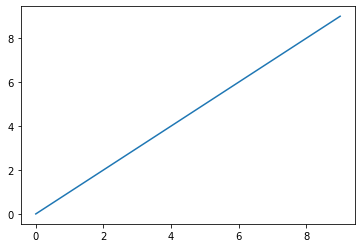

In [ ]:
plt.plot([i for i in range(10)], range(10))